In [18]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Electric_Production.csv', index_col = "DATE", parse_dates = True)

In [4]:
df.shape

(397, 1)

In [5]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


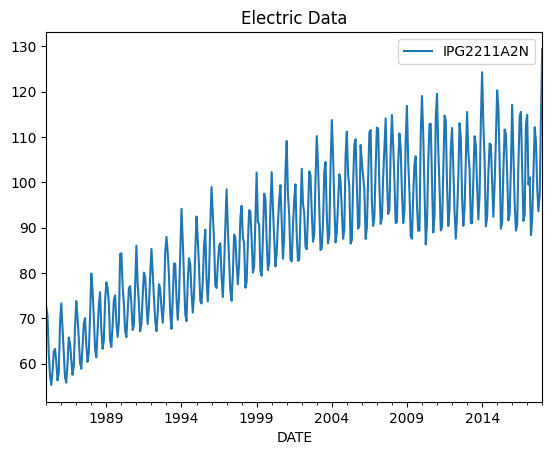

In [7]:
df[['IPG2211A2N']].plot(title='Electric Data')
plt.show()

In [8]:
df.index

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

In [9]:
df.index.freq = "MS"

In [12]:
train = df[:373]
test = df[373:]

In [13]:
len(test)

24

In [14]:
#################################
# Triple Exponential Smoothing (Holt-Winters)
#################################

In [15]:
def tes_optimizer(train, abg, step=24):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [16]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [19]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 3.49]
[0.1, 0.1, 0.3, 4.05]
[0.1, 0.1, 0.5, 4.67]
[0.1, 0.1, 0.7, 5.02]
[0.1, 0.1, 0.9, 5.04]
[0.1, 0.3, 0.1, 7.46]
[0.1, 0.3, 0.3, 7.98]
[0.1, 0.3, 0.5, 8.01]
[0.1, 0.3, 0.7, 7.64]
[0.1, 0.3, 0.9, 6.69]
[0.1, 0.5, 0.1, 8.35]
[0.1, 0.5, 0.3, 10.41]
[0.1, 0.5, 0.5, 10.76]
[0.1, 0.5, 0.7, 9.7]
[0.1, 0.5, 0.9, 8.72]
[0.1, 0.7, 0.1, 11.91]
[0.1, 0.7, 0.3, 15.36]
[0.1, 0.7, 0.5, 15.52]
[0.1, 0.7, 0.7, 5.15]
[0.1, 0.7, 0.9, 7.68]
[0.1, 0.9, 0.1, 17.71]
[0.1, 0.9, 0.3, 23.81]
[0.1, 0.9, 0.5, 24.82]
[0.1, 0.9, 0.7, 28.3]
[0.1, 0.9, 0.9, 167.34]
[0.3, 0.1, 0.1, 5.9]
[0.3, 0.1, 0.3, 8.19]
[0.3, 0.1, 0.5, 9.67]
[0.3, 0.1, 0.7, 11.48]
[0.3, 0.1, 0.9, 14.71]
[0.3, 0.3, 0.1, 10.47]
[0.3, 0.3, 0.3, 17.78]
[0.3, 0.3, 0.5, 19.11]
[0.3, 0.3, 0.7, 29.11]
[0.3, 0.3, 0.9, 38.18]
[0.3, 0.5, 0.1, 7.4]
[0.3, 0.5, 0.3, 17.45]
[0.3, 0.5, 0.5, 21.59]
[0.3, 0.5, 0.7, 21.59]
[0.3, 0.5, 0.9, 671.34]
[0.3, 0.7, 0.1, 3.36]
[0.3, 0.7, 0.3, 17.61]
[0.3, 0.7, 0.5, 19.79]
[0.3, 0.7, 0.7, 1370.56]
[0.3, 0.

In [20]:
tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [21]:
y_pred = tes_model.forecast(24)


In [44]:
def plot_prediction(y_pred, label):
    plt.figure(figsize=(15, 9))
    train["IPG2211A2N"].plot(legend=True, label="TRAIN")
    test["IPG2211A2N"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()


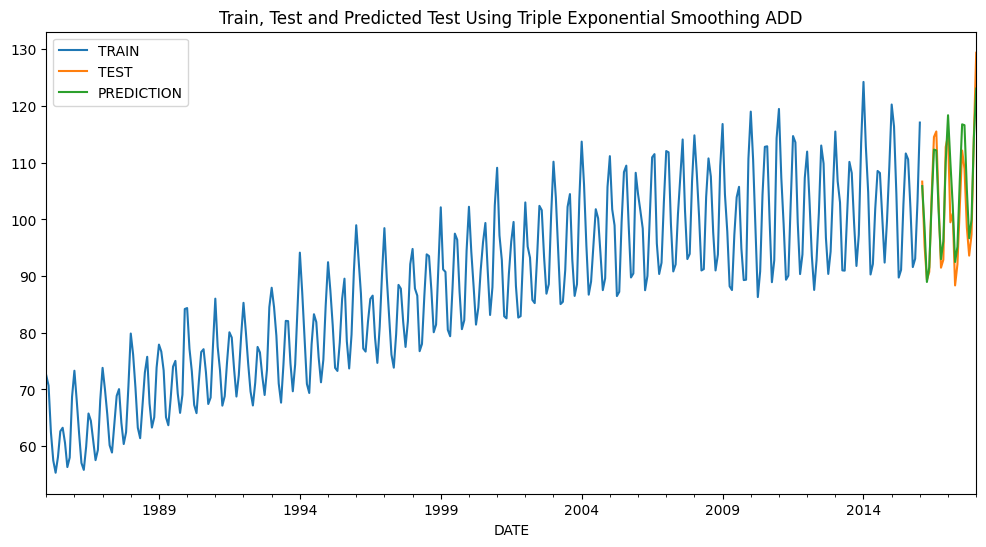

In [32]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

In [33]:
##################################################
# SARIMA
##################################################

In [34]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [35]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4411.128898626809
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3951.646076453382
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1932.4113874710868
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1931.058241826687
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2075.0332719678536
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2073.719919681589
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1930.7406334522475
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1932.7064673202208
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3924.4669266576057
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3482.6028192382537
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1787.2869214062582
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1772.7975797875545
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2081.8638657690954
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1903.9268135940317
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1773.9405598379926
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1774.6745883886579
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2563.021859926941
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [36]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)

y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)

3.173413305131738

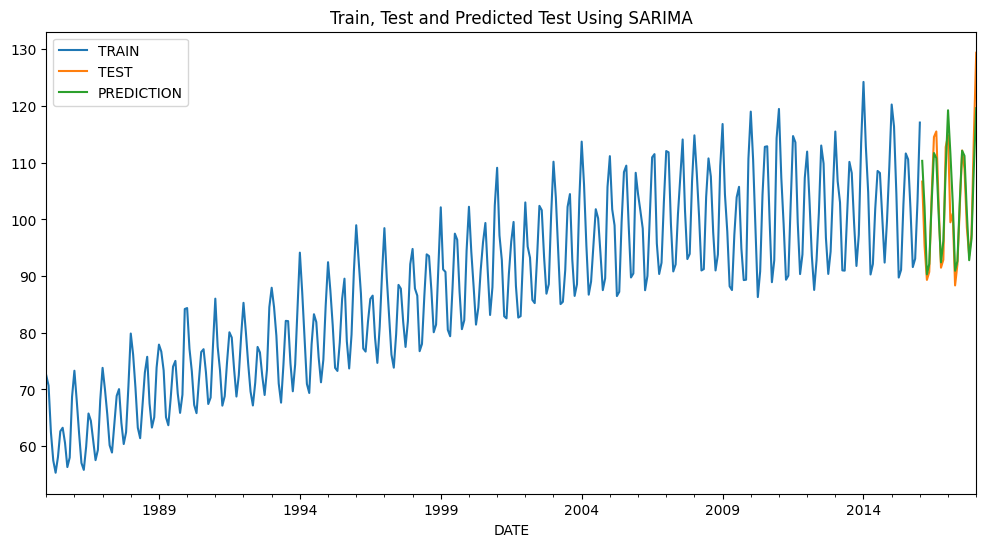

In [37]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

In [48]:
# MAE Iteration

In [40]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [41]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:102.86798749999998
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:78.30091532792112
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:4.1883375
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.135933731583892
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:4.180971905934675
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.129845843075555
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:4.149791085079649
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:4.158021842841684
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:99.83740508415588
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:76.39225560508625
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.108543737575222
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:3.9619671292076197
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.083106223186621
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:3.954826447610291
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:4.049092333403142
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:3.979044044363283
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:15.242470833333329
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:12.550526427501

In [42]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)

3.173413305131738

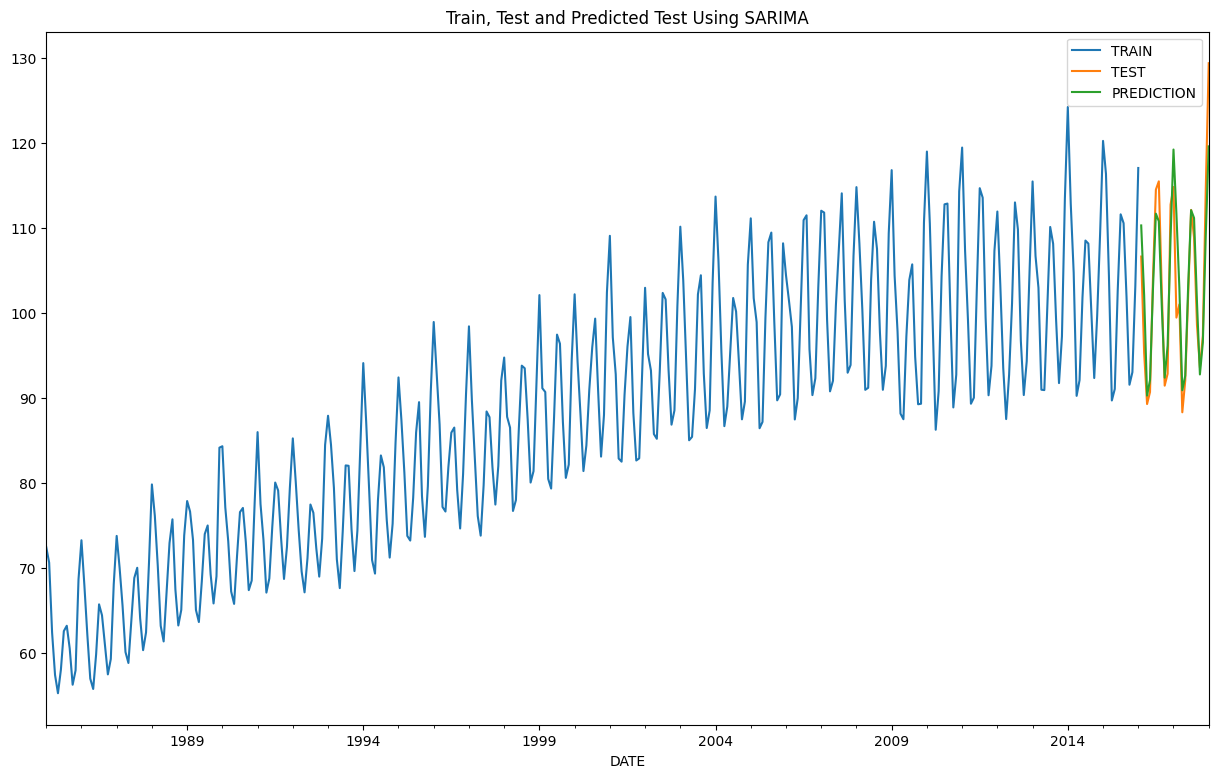

In [45]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

In [46]:
# Final model

In [47]:
tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

tes_model_final.forecast(6)

,0
2018-02-01,117.823733
2018-03-01,114.418003
2018-04-01,108.186618
2018-05-01,114.359816
2018-06-01,128.834017
2018-07-01,141.251466
